<a href="https://colab.research.google.com/github/Gurad1an/code_review/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of [Learning Representations and Generative Models for 3D Point Clouds](https://arxiv.org/abs/1707.02392)



## Clone the [repository](https://github.com/square-1111/Learning-Representations-and-Generative-Models-for-3D-Point-Clouds) to get necessary files

In [1]:
!git clone https://github.com/square-1111/3D_Latent/
!mv 3D_Latent/* .
!rm -r 3D_Latent/

Cloning into '3D_Latent'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 33 (delta 11), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (33/33), 405.72 KiB | 387.00 KiB/s, done.


## Imports

In [2]:
!pip install plyfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os, glob, subprocess
import numpy as np
import stat

from plyfile import PlyData, PlyElement
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import torch
from torch.utils import data
import torch.nn as nn
import torch.autograd as autograd

from IPython import display
import matplotlib.pyplot as plt

In [4]:
import make_data, loss, utils, train_ae
from ae_model import AutoEncoder
import train_gan
from lat_gan_model import latentGenerator, latentDiscriminator
from raw_gan_model import rawDiscriminator, rawGenerator

/content/train_ae.py:29: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if curr_epoch is not -1:


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data  
Using [ShapeNet Core](https://www.shapenet.org/) data. For each mesh model Shape-net-core download 1 point cloud with 2048 points 


### Download data and basic directory management

In [6]:
os.chmod('dataDownload.sh',stat.S_IRUSR|stat.S_IWUSR|stat.S_IXUSR)
!./dataDownload.sh

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: shape_net_core_uniform_samples_2048/02958343/ac813039f9a4468ccc777d23edf2f8d8.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/8e8da02ac0168a47ec5e3fe5c33367cf.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/f20c5d6963d8e2d412ecbedd3e0be919.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/b6755cab505f437375cad724c63e222e.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/fa260cad93890a33d5a3fe1d8a0a8597.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/274bb81c9dd9420b748999a5d81a158c.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/121d6b29eb65827287dc1da2515df8f7.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/52abca690cceb7c634a65e2e5c663c7e.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/3fda3ac98502252a66193ee695e5d3f2.ply  
  inflating: shape_net_core_uniform_samples_2048/02958343/dd84236f0ef27765a134736201a79843.ply  
  i

In [7]:
#@title Select Object from specified list { display-mode: "form" }
obj = 'plane' #@param ['plane', 'bag', 'basket', 'bathtub', 'bed', 'bench','bicycle', 'birdhouse',  'bookshelf', 'bottle', 'bowl', 'bus', 'cabinet', 'can', 'camera', 'cap', 'car', 'chair', 'clock', 'dishwasher', 'monitor', 'table', 'telephone', 'tin_can', 'tower', 'train', 'keyboard', 'earphone', 'faucet', 'file', 'guitar', 'helmet', 'jar', 'knife', 'lamp', 'laptop', 'speaker', 'mailbox', 'microphone', 'microwave', 'motorcycle', 'mug', 'piano', 'pillow', 'pistol', 'pot', 'printer', 'remote_control', 'rifle', 'rocket', 'skateboard', 'sofa', 'stove', 'watercraft', 'washer', 'boat', 'cellphone'] {allow-input: true}

In [8]:
utils.plotPointCloud(obj)

## Autoencoder

#### Encoder and Decoder Configuration

In [9]:
# Encoder Parameters
bneck_size = 128
encoder_args = {'n_filters': [2048, 64, 128, 128, 256, bneck_size],
                'filter_sizes': [1],
                'stride': [1],
                'b_norm': True,
                'verbose': True,
                'non_linearity' : nn.ReLU,
                'weight_decay' : 0.001,
                'dropout_prob' : None,
                'pool' : nn.AvgPool1d,
                'pool_sizes' : None,
                'padding' : 0, 
                'padding_mode' : 'zeros',
                'conv_op' : nn.Conv1d,
                'symmetry' : torch.max, 
                'closing' : None
                }
# Decoder Parameters
decoder_args = {'layer_sizes': [128, 256, 256, 2048*3],
                'b_norm': False,
                'b_norm_finish': False,
                'verbose': True,
                'non_linearity' : nn.ReLU,
                'dropout_prob' : None
                }

#### Parameters for Autoencoder

In [10]:
num_epochs = 1000
learning_rate = 0.0005
saver_step = 10
loss_display_step = 1

params_ae = {'batch_size': 16,
             'shuffle': True
             }

In [11]:
# Using the object input as dataset 
training_set_ae = make_data.Data(obj)
training_generator_ae = data.DataLoader(training_set_ae, **params_ae)

### Training Autoencoder : Chamfer Metrics


In [12]:
autoencoder_ch = AutoEncoder(encoder_args, decoder_args)

Building Encoder
Building Decoder


In [13]:
autoencoder_ch

AutoEncoder(
  (encoder): Encoder(
    (model): ModuleList(
      (0): Conv1d(2048, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
    )
  )
  (decoder): DecoderWithFC(
    (model): ModuleList(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=6144, bias=True)
      (5): ReLU()
      (6): Linear(in_features=6144, out_features=6144, bias=True)
    )
  )
)

In [14]:
# Optimizer
optimizer_ae = torch.optim.Adam(autoencoder_ch.parameters(),lr=learning_rate)

# Autoencoder with Chamfer Loss
autoencoder_ch.name = 'Autoencoder CH'

# Loss Dictionary
loss_dict = {autoencoder_ch.name : []}

# Path to store model Autoencoder with Chamfer Loss
path_AE_ch =  'drive/My Drive/PointCloud/AE_CH/'

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

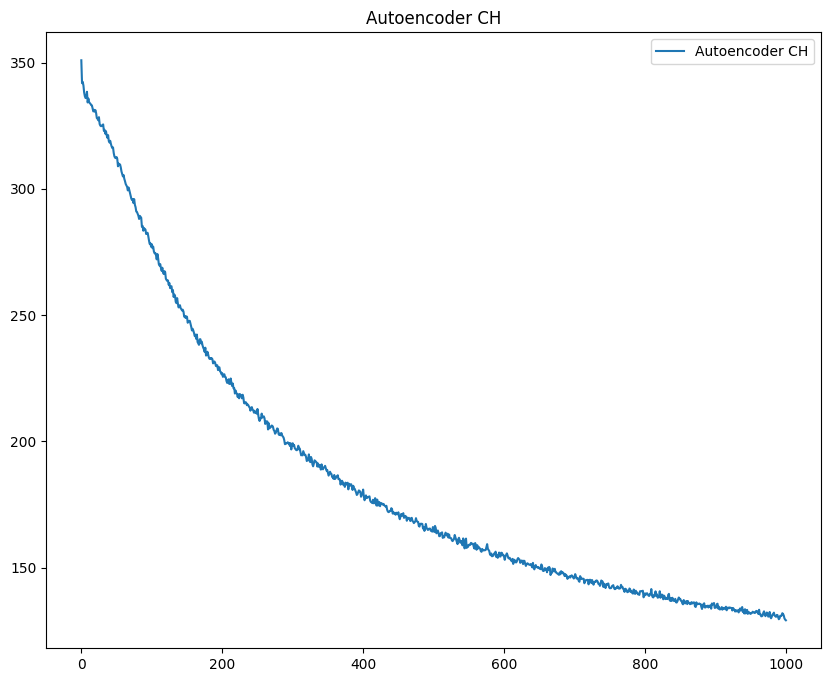

1000


In [15]:
train_ae.trainingLoopAE(obj, autoencoder_ch, num_epochs, 
                        training_generator_ae,
                        loss.chamferLossBatch,
                        optimizer_ae,
                        loss_dict,
                        path_AE_ch, device)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Training Autoencoder : Earth Mover Metrics

In [18]:
autoencoder_em = AutoEncoder(encoder_args, decoder_args)

Building Encoder
Building Decoder


In [19]:
autoencoder_em

AutoEncoder(
  (encoder): Encoder(
    (model): ModuleList(
      (0): Conv1d(2048, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (3): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (4): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
    )
  )
  (decoder): DecoderWithFC(
    (model): ModuleList(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=6144, bias=True)
      (5): ReLU()
      (6): Linear(in_features=6144, out_features=6144, bias=True)
    )
  )
)

In [20]:
# Optimizer
optimizer_ae = torch.optim.Adam(autoencoder_em.parameters(),lr=learning_rate)

# Autoencoder with Earth Mover Distance
autoencoder_em.name = 'Autoencoder EM'

# Loss Dictionary
loss_dict = {autoencoder_em.name : []}

# Path to store model Autoencoder with Chamfer Loss
path_AE_EM =  'drive/My Drive/PointCloud/AE_EM'

In [22]:
train_ae.trainingLoopAE(obj, autoencoder_em, num_epochs, 
                        training_generator_ae,
                        loss.EMDBatch,
                        optimizer_ae,
                        loss_dict,
                        path_AE_EM, device)

OutOfMemoryError: ignored

## Latent GAN

#### Generator Architecture

In [ ]:
lat_gen_args = {'layer_sizes' : [128, 128 ,2048*3],
                'b_norm' : False,
                'b_norm_finish': False,
                'verbose': False,
                'non_linearity' : nn.ReLU,
                'dropout_prob' : None}
latGen = latentGenerator(lat_gen_args)
latGen

latentGenerator(
  (generator): DecoderWithFC(
    (model): ModuleList(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=6144, bias=True)
      (3): ReLU()
      (4): Linear(in_features=6144, out_features=6144, bias=True)
    )
  )
)

#### Discriminator Network

In [ ]:
lat_dis_args = {'layer_sizes': [2048*3, 256, 512, 1],
                'b_norm': False,
                'b_norm_finish': False,
                'verbose': True,
                'non_linearity' : nn.ReLU,
                'dropout_prob' : None
                }
latDisc = latentDiscriminator(lat_dis_args)
latDisc

Building Decoder


latentDiscriminator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): DecoderWithFC(
    (model): ModuleList(
      (0): Linear(in_features=6144, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): ReLU()
      (6): Linear(in_features=1, out_features=1, bias=True)
    )
  )
  (sigmoid): Sigmoid()
)

##### Parameters for Latent GAN

In [ ]:
num_epochs_lat_gan = 2000
learning_rate_lat_gan = 0.0001
saver_step = 10
loss_display_step = 1

params_lat_gan = {'batch_size': 50,
                  'shuffle': True
                  }

In [ ]:
# Using the object inputted as dataset 
training_set_gan = make_data.Data(obj)
training_generator_gan = data.DataLoader(training_set_gan, **params_lat_gan)

In [ ]:
# Optimizer
optimizer_lat_g = torch.optim.Adam(latGen.parameters(),
                                   lr=learning_rate_lat_gan,
                                   betas=(0.5, 0.999))
# Optimizer
optimizer_lat_d = torch.optim.Adam(latDisc.parameters(),
                                   lr=learning_rate_lat_gan,
                                   betas=(0.5, 0.999))

In [ ]:
# Latent GAN
latDisc.name = 'Latent Discriminator'
latGen.name = 'Latent Generator'

# Loss Dictionary
loss_dict_lat_gan = {latGen.name : [] ,latDisc.name : []}

# Path to store model Autoencoder with Chamfer Loss
path_lat_GAN =  'drive/My Drive/PointCloud/Lat_GAN'

#### Training Latent GAN

In [ ]:
train_gan.trainingLoopGAN(obj, training_generator_gan,latGen, latDisc, 
                          'Latent_GAN', num_epochs_lat_gan, 
                          optimizer_lat_g, optimizer_lat_d,
                          loss_dict_lat_gan, path_lat_GAN, device)

## Raw GAN

#### Generator Architecture

In [ ]:
raw_gen_args = {'layer_sizes' : [128, 64, 128, 512, 1024, 2048*3],
                'b_norm' : False,
                'b_norm_finish': False,
                'verbose': False,
                'non_linearity' : nn.ReLU,
                'dropout_prob' : None}
rawGen = rawGenerator(raw_gen_args)
rawGen

rawGenerator(
  (generator): DecoderWithFC(
    (model): ModuleList(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=1024, bias=True)
      (7): ReLU()
      (8): Linear(in_features=1024, out_features=6144, bias=True)
      (9): ReLU()
      (10): Linear(in_features=6144, out_features=6144, bias=True)
    )
  )
)

#### Discriminator Network

In [ ]:
# Encoder Parameters
bneck_size = 128
raw_disc_args = {'n_filters': [2048, 64, 128, 256, 256, 512],
                'filter_sizes': [1],
                'stride': [1],
                'b_norm': True,
                'verbose': True,
                'non_linearity' : nn.LeakyReLU,
                'weight_decay' : 0.001,
                'dropout_prob' : None,
                'pool' : nn.MaxPool1d,
                'pool_sizes' : None,
                'padding' : 0, 
                'padding_mode' : 'zeros',
                'conv_op' : nn.Conv1d,
                'closing' : None,
                'linear_layer' : [512*3, 128, 64, 1]
                }
rawDisc = rawDiscriminator(raw_disc_args)
rawDisc

Building Discriminator


rawDiscriminator(
  (model): ModuleList(
    (0): Conv1d(2048, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Conv1d(256, 512, kernel_size=(1,)

##### Parameters for Raw GAN

In [ ]:
num_epochs_raw_gan = 2000
learning_rate_raw_gan = 0.0001
saver_step = 10
loss_display_step = 1

params_raw_gan = {'batch_size': 50,
                  'shuffle': True
                  }

In [ ]:
# Using the object inputted as dataset 
training_set_gan = make_data.Data(obj)
training_generator_gan = data.DataLoader(training_set_gan, **params_raw_gan)

In [ ]:
# Optimizer
optimizer_raw_g = torch.optim.Adam(rawGen.parameters(),
                                   lr=learning_rate_raw_gan,
                                   betas=(0.5, 0.999))
# Optimizer
optimizer_raw_d = torch.optim.Adam(rawDisc.parameters(),
                                   lr=learning_rate_raw_gan,
                                   betas=(0.5, 0.999))

In [ ]:
# Raw GAN
rawDisc.name = 'Raw Discriminator'
rawGen.name = 'Raw Generator'

# Loss Dictionary
loss_dict_raw_gan = {rawGen.name : [] ,rawDisc.name : []}

# Path to store model Autoencoder with Chamfer Loss
path_raw_GAN =  'drive/My Drive/PointCloud/Raw_GAN/'

#### Training Raw GAN

In [ ]:
train_gan.trainingLoopGAN(obj, training_generator_gan, rawGen, rawDisc, 
                          'Raw_GAN', num_epochs_lat_gan, 
                          optimizer_raw_g, optimizer_raw_d,
                          loss_dict_raw_gan, path_raw_GAN, device)